# DiracPy Tutorial - Part 2

## Quantum systems in diracpy

The `qsys` class in diracpy creates quantum systems around a given Hamiltonian. To understand what a diracpy `qsys` is and why it is needed, we need to first explain the front-end and back-end of diracpy. The front-end presents the user with the interface to define bras, kets and operators. This was covered in part 1 of this tutorial, and allows these objects to be coded in the same way they would be written in Dirac notation. The back-end supports several methods to solve the quantum dynamics under a given Hamiltonian.

Ultimately, to solve the dynamics, the abstract dirac vectors and operators must be written explicitly using lineary algebra (using numpy arrays in our case). The `qsys` class takes a Hamiltonian and the inital state of the system, then finds an appropriate basis to describe the system, and defines the Hamiltonian matrix in this basis.

## Numericall integration of the von Neumann equation

Consider the quantum system with the Jaynes-Cummings Hamiltonian
$$
    H = \sigma_z \Delta 
    + g (a^{\dagger} \sigma_- + a \sigma_+)
$$
where $g$ is the interaction strength (frequency) and $\Delta = \omega_0-\omega$ is the detuning between the resonance of a single mode cavity and a two level system.

In [2]:
import matplotlib.pyplot as plt
import diracpy as dp
import numpy as np

In [5]:
# define state space
atom = dp.two_level_subspace(index=0)
cav = dp.fock_subspace(index=1)
# define model parameters
Delta, g = 0, np.pi
# define Hamiltonian
H_0 = Delta * atom.sigma_z
V = g * (cav.a * atom.sigma_plus + cav.adag * atom.sigma_minus)
H = H_0 + V

In [9]:
# Define initial state and quantum system
psi0 = dp.ket(['e',0])
system = dp.qsys(H, initialstates=[psi0], n_int=2)

In [14]:
# definine initial density operator rho0
rho0 = psi0 * psi0.conj()
# times to solve for
times = np.linspace(0,2,50)
# solve the vonneumann equation
vnsolve = dp.vonneumannint(rho0, times, system)

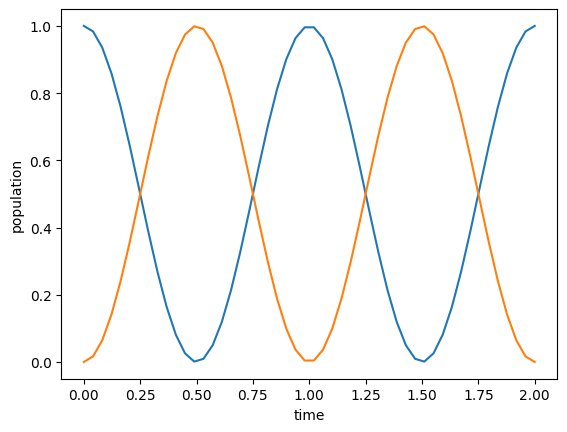

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(times, vnsolve.soln[:,0,0])
ax.plot(times, vnsolve.soln[:,1,1])
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

## Time dependent quantum systems

An example of a time dependent quantum system given by the Hamiltonian
$$
    H = \sigma_z \Delta 
    + \frac12 \Omega(t) (a^{\dagger} \sigma_- + a \sigma_+)
$$
where $\Omega(t) = \Omega \sin (\pi t)^2$ for $0<t<1$, and $\Delta = \omega_0-\omega$ is the detuning of a coherent driving field from resonance of the two level system.

In [1]:
import matplotlib.pyplot as plt
import diracpy as dp
import numpy as np

In [9]:
def f(t):
    return np.sin(np.pi * t)**2

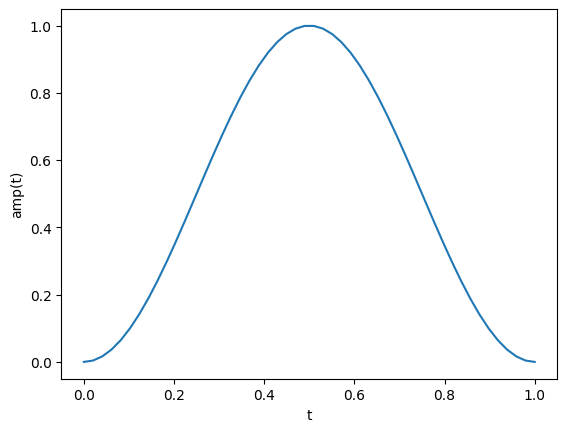

In [8]:
fig, ax = plt.subplots(1,1)
times = np.linspace(0,1,50)
ax.plot(times, amp(times))
ax.set_xlabel('t')
ax.set_ylabel('amp(t)')
plt.show()

We next define the state spaces for the atom and field, and the term of the hamiltonian.

In [12]:
atom = dp.two_level_subspace(index=0)
laser = dp.floquet_subspace(index=1)

Delta, Omega = 0, 1

H_0 = Delta * atom.sigma_z
V = 0.5 * Omega * (laser.a * atom.sigma_plus + laser.adag * atom.sigma_minus)

where the time dependent Hamiltonian would be given by `H_0 + f(t) * V`.
However, diracpy only recognises `f(t)*V` when a time `t` is defined and thus `f(f)` returns a scalar. Instead, define a time dependent quantum system `dp.qsys_t` and pass the static part of the Hamiltonian, `H_0`, the dynamic part `V` and the function of the dynamic coefficient, `f`.

In [16]:
psi0 = dp.ket(['g',0])
system = dp.qsys_t(H_0, [V], [f], initialstates=[psi0], n_int=2)

We can now access the time dependent Hamiltonian, which at `t=0.5` is

In [18]:
system.ham(0.5)

array([[0. +0.j, 0.5+0.j],
       [0.5+0.j, 0. +0.j]])

and at `t=0` is

In [19]:
system.ham(0)

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])